## 🌐 **Google Drive Connection**

In [ ]:
# 1️⃣ Import delle librerie principali
import matplotlib.pyplot as plt
import pandas as pd
import logging
import random
import numpy as np
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
import copy
import shutil
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import os

# 2️⃣ Definisci la directory principale nel workspace di Colab
current_dir = '/content/Arialeto2'

# 3️⃣ Crea la directory se non esiste
os.makedirs(current_dir, exist_ok=True)

# 4️⃣ Spostati nella directory del progetto
os.chdir(current_dir)
print(f"Working directory set to: {os.getcwd()}")

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1-GldjmW2UkrRzoKRsp0d_0BiDCphSh44/Arialeto2


## ⚙️ **Libraries Import**

In [ ]:
# Set seed for reproducibility
SEED = 21

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

import cv2

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader

# Configurazione di TensorBoard e directory
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.gridspec as gridspec

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
PyTorch version: 2.9.0+cu126
Device: cuda


## ⏳ **Data Loading**

In [ ]:
dataset_path = 'clean_patches/'

In [ ]:
def load_images_from_folder(folder):
    """
    Load and preprocess images from a specified folder.

    Args:
        folder (str): Path to the folder containing images

    Returns:
        tuple: (np.ndarray, list) - Array of preprocessed images with shape (N, H, W, C) and a list of corresponding filenames.
    """
    images = []
    filenames = []

    # Get all image filenames first and sort them to ensure consistent order
    all_filenames = sorted([f for f in os.listdir(folder) if not f.startswith('mask') and not f.startswith('.')])

    for filename in all_filenames:
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)

        # Normalize image pixel values to a float range [0, 1]
        img = (img / 255).astype(np.float32)

        # Convert image from BGR to RGB
        img = img[...,::-1]

        if img is not None:
            images.append(img)
            filenames.append(filename) # Store filename as well

    return np.array(images), filenames

In [ ]:
dataset, dataset_filenames = load_images_from_folder(dataset_path)

print(f"Loaded {len(dataset)} images")

Loaded 3907 images


##CSV IMAGE MAPPING LABEL

In [ ]:
df_labels = pd.read_csv("train_labels.csv")
df_labels.head()

,sample_index,label
0,img_0000.png,Triple negative
1,img_0001.png,Luminal B
2,img_0002.png,Luminal B
3,img_0003.png,Luminal B
4,img_0004.png,Luminal B


In [ ]:
# Get unique labels and store them in unique_labels variable
unique_labels = df_labels['label'].unique()
print(f"Unique labels: {unique_labels}")
class_to_id = {c: i for i, c in enumerate(unique_labels)}
print(f"Label mapping: {class_to_id}")

Unique labels: ['Triple negative' 'Luminal B' 'HER2(+)' 'Luminal A']
Label mapping: {'Triple negative': 0, 'Luminal B': 1, 'HER2(+)': 2, 'Luminal A': 3}


In [ ]:
patch_labels_data = []

for patch_filename in dataset_filenames:
    # Extract the base image name (e.g., 'img_0000.png' from 'img_0000_patch_0.png')
    base_image_name = patch_filename.split('_patch_')[0] + '.png'

    # Find the corresponding label in df_labels
    label_row = df_labels[df_labels['sample_index'] == base_image_name]

    if not label_row.empty:
        corresponding_label = label_row['label'].iloc[0]
        patch_labels_data.append({'sample_index': patch_filename, 'label': corresponding_label})

# Convert the list of dictionaries to a pandas DataFrame
df_labels_patch = pd.DataFrame(patch_labels_data)

# Print the head of the new DataFrame to verify
print(df_labels_patch.head())

             sample_index            label
0  img_0000_patch_000.png  Triple negative
1  img_0002_patch_000.png        Luminal B
2  img_0002_patch_001.png        Luminal B
3  img_0002_patch_002.png        Luminal B
4  img_0002_patch_003.png        Luminal B


## 🔎 **Exploration and Data Analysis**

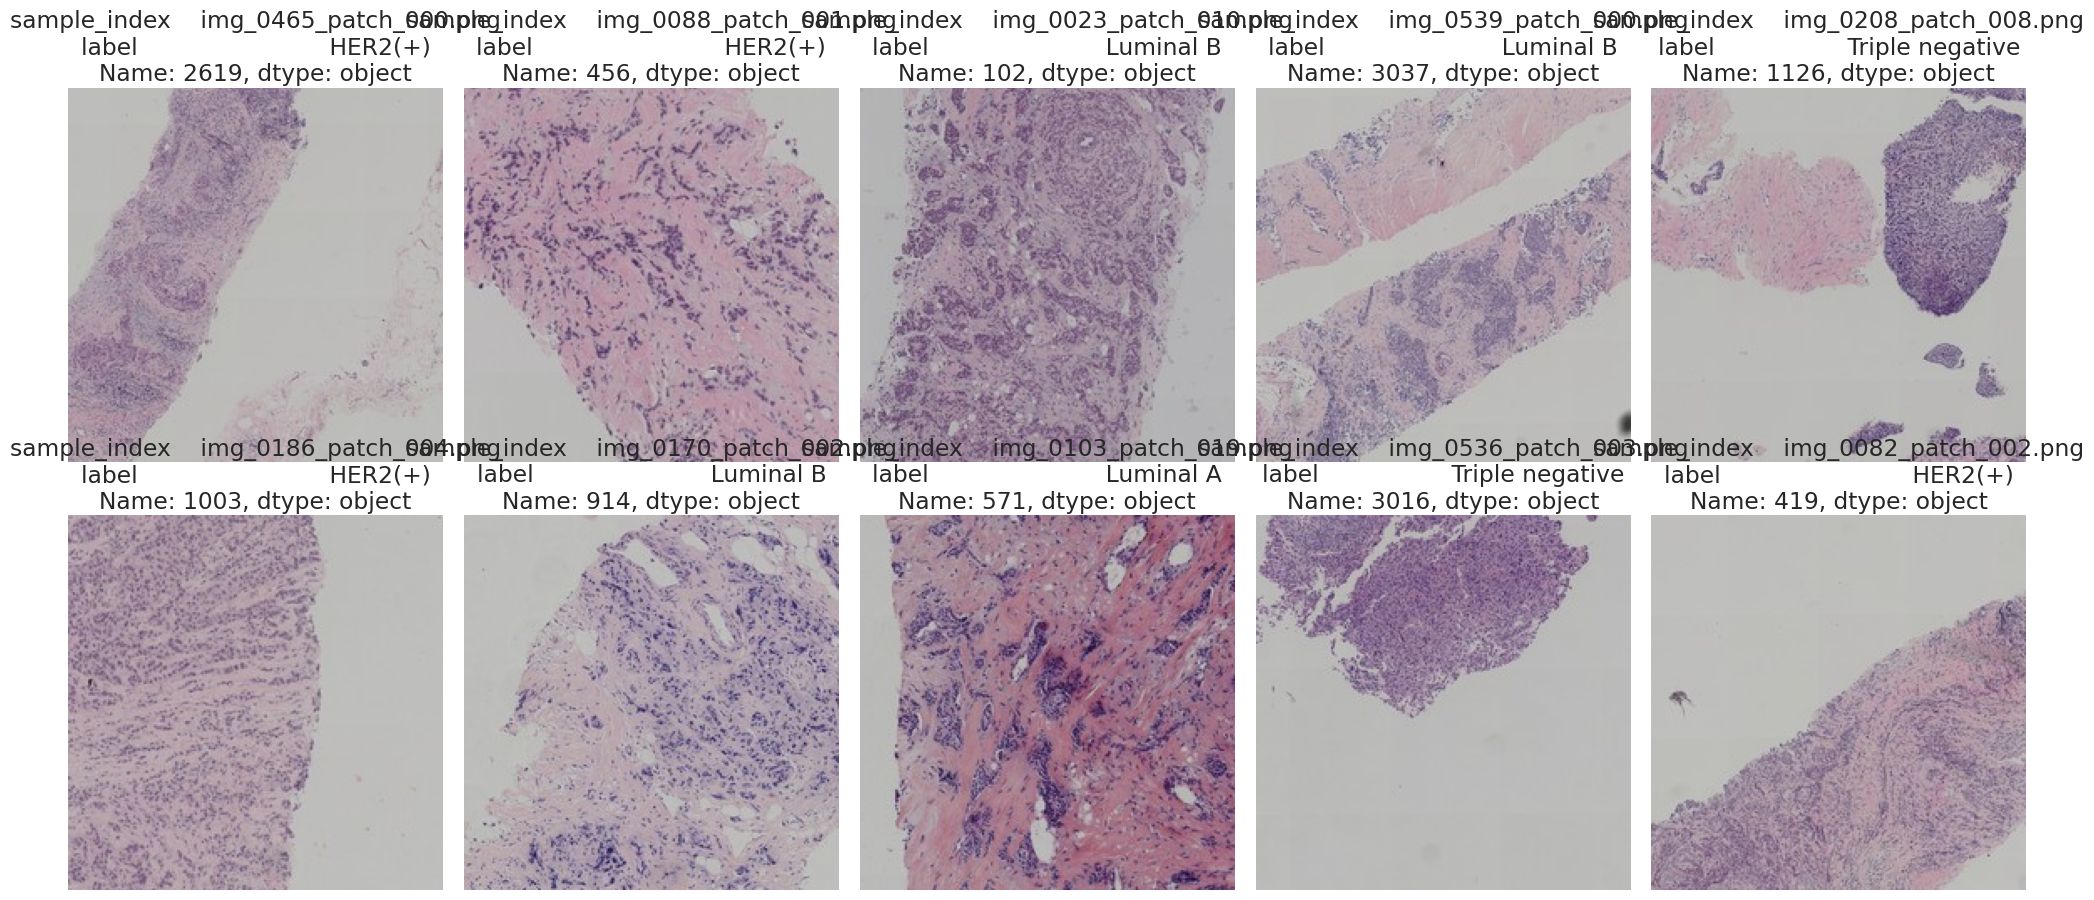

In [ ]:
# Number of images to display
num_img = 10
# Select random indices from the training set
random_indices = random.sample(range(len(dataset)), num_img)

# Create subplot layout for images
fig, axes = plt.subplots(2, num_img // 2, figsize=(20, 9))

for i, idx in enumerate(random_indices):
    ax = axes[i // 5, i % 5]

    # Display the image at the selected index (convert CHW to HWC)
    img = dataset[idx]
    ax.imshow(img)

    # Add class name as title
    class_name = df_labels_patch.iloc[idx]
    class_name = class_name.replace('_', ' ')
    ax.set_title(class_name, pad=5)

    # Remove axis lines for clearer display
    ax.axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

##PLOT CLASS DISTRIBUTION

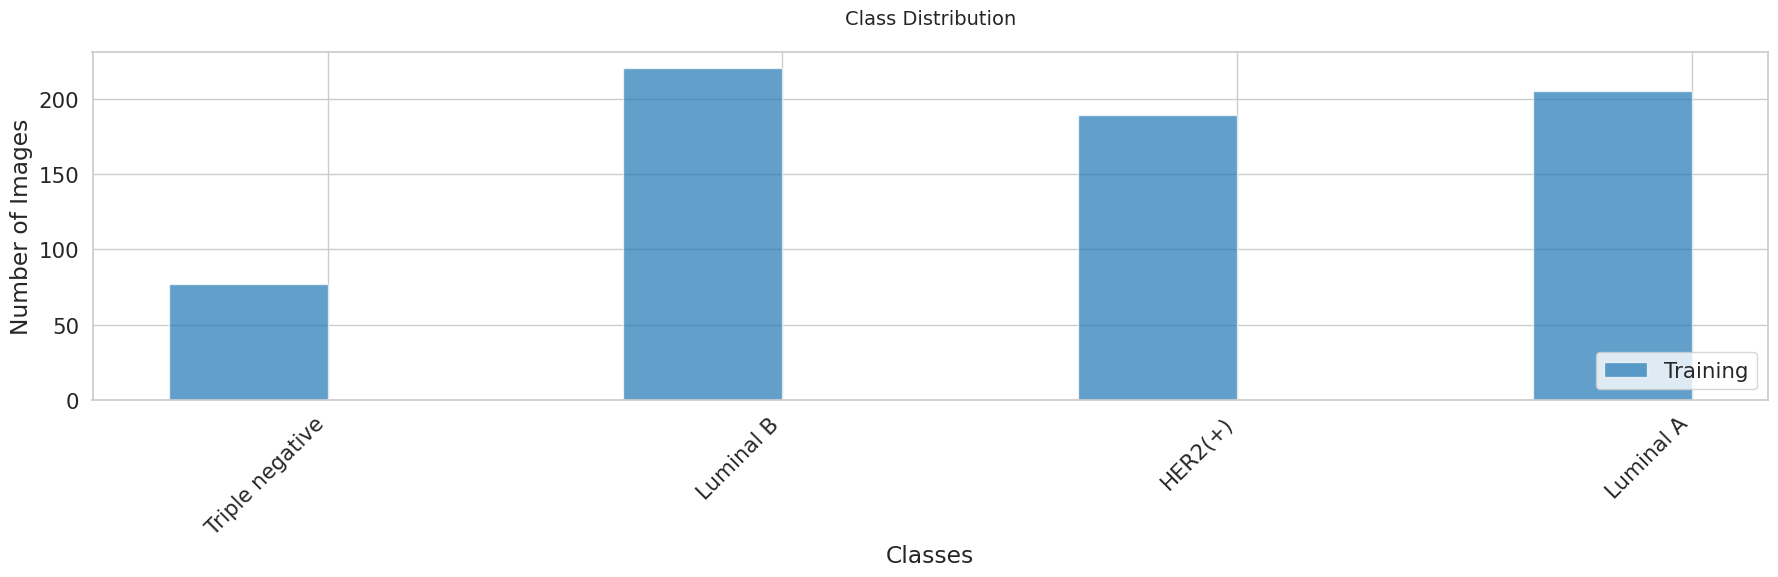

In [ ]:
def plot_class_distribution(y_train, class_names):
    """Plot class distribution for training and test sets."""
    sns.set_style("whitegrid")
    plt.figure(figsize=(18, 6))

    # Calculate class distributions for training and test sets
    train_dist = np.bincount(y_train)
    #test_dist = np.bincount(y_test)

    # Create x positions and set bar width
    x = np.arange(len(class_names))
    width = 0.35

    # Plot bars for training and test distributions
    plt.bar(x - width / 2, train_dist, width, label='Training', color='#1f77b4', alpha=0.7)
    #plt.bar(x + width / 2, test_dist, width, label='Test', color='#ff7f0e', alpha=0.7)

    # Customize plot title and labels
    plt.title('Class Distribution', pad=20, fontsize=14)
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')

    # Set class names as x-axis labels with rotation
    plt.xticks(x, class_names, rotation=45, ha='right')

    # Add legend for training and test distributions
    plt.legend(loc='lower right')

    # Adjust layout for optimal spacing
    plt.tight_layout()
    plt.show()

# 1) estrai le etichette come Series
labels = df_labels['label']          # o la colonna giusta

# 2) crea una mappa classe -> intero
class_names = labels.unique()
class_to_id = {c: i for i, c in enumerate(class_names)}

# 3) converti le label testuali in ID interi
y_train = labels.map(class_to_id).to_numpy()   # array 1D di int

# 4) ora puoi usare la tua funzione
plot_class_distribution(y_train, class_names)

## 🔄 **Data Preprocessing**

In [ ]:
y_train_val_df = df_labels_patch.copy()
y_train_val = y_train_val_df['label']

# Convert string labels to integer IDs using the predefined mapping
y_train_val = y_train_val.map(class_to_id)

print("First 5 elements of y_train_val:")
print(y_train_val.head())

First 5 elements of y_train_val:
0    0
1    1
2    1
3    1
4    1
Name: label, dtype: int64


In [ ]:
df_labels_patch['original_image_id'] = df_labels_patch['sample_index'].apply(lambda x: x.split('_patch_')[0] + '.png')

# Create a new DataFrame containing unique original image IDs and their labels
original_images_df = df_labels_patch[['original_image_id', 'label']].drop_duplicates().reset_index(drop=True)

# Verify the mapping by merging with df_labels to ensure consistency
# This step ensures that the 'label' associated with 'original_image_id' in original_images_df
# is consistent with the 'label' in the original df_labels for that 'sample_index'.
original_images_df = pd.merge(original_images_df, df_labels[['sample_index', 'label']],
                                  left_on='original_image_id', right_on='sample_index', how='left', suffixes=('_patch', '_original'))

# Keep only the original label if there's a conflict or simply verify
# Assuming the labels in df_labels are the ground truth for original images
original_images_df['label'] = original_images_df['label_original']
original_images_df = original_images_df[['original_image_id', 'label']]

print("First 5 rows of df_labels_patch with original_image_id:")
print(df_labels_patch.head())
print("\nFirst 5 rows of original_images_df:")
print(original_images_df.head())
print(f"\nTotal unique original images: {len(original_images_df)}")


First 5 rows of df_labels_patch with original_image_id:
             sample_index            label original_image_id
0  img_0000_patch_000.png  Triple negative      img_0000.png
1  img_0002_patch_000.png        Luminal B      img_0002.png
2  img_0002_patch_001.png        Luminal B      img_0002.png
3  img_0002_patch_002.png        Luminal B      img_0002.png
4  img_0002_patch_003.png        Luminal B      img_0002.png

First 5 rows of original_images_df:
  original_image_id            label
0      img_0000.png  Triple negative
1      img_0002.png        Luminal B
2      img_0003.png        Luminal B
3      img_0004.png        Luminal B
4      img_0006.png        Luminal A

Total unique original images: 578


In [ ]:
original_images_df['label_id'] = original_images_df['label'].map(class_to_id)

# Split original image IDs into training and validation sets, stratified by label
train_original_image_ids, val_original_image_ids = train_test_split(
    original_images_df['original_image_id'],
    test_size=0.2,
    random_state=SEED,
    stratify=original_images_df['label_id']
)

print(f"Number of original images in training set: {len(train_original_image_ids)}")
print(f"Number of original images in validation set: {len(val_original_image_ids)}")
print("First 5 training original image IDs:")
print(train_original_image_ids.head())
print("\nFirst 5 validation original image IDs:")
print(val_original_image_ids.head())

Number of original images in training set: 462
Number of original images in validation set: 116
First 5 training original image IDs:
162    img_0202.png
132    img_0163.png
347    img_0408.png
219    img_0262.png
105    img_0125.png
Name: original_image_id, dtype: object

First 5 validation original image IDs:
123    img_0151.png
71     img_0088.png
231    img_0276.png
430    img_0504.png
308    img_0362.png
Name: original_image_id, dtype: object


In [ ]:
train_patches_df = df_labels_patch[df_labels_patch['original_image_id'].isin(train_original_image_ids)]
val_patches_df = df_labels_patch[df_labels_patch['original_image_id'].isin(val_original_image_ids)]

# Get the original indices of these patches from the 'dataset_filenames' list
train_patch_indices = [dataset_filenames.index(f) for f in train_patches_df['sample_index']]
val_patch_indices = [dataset_filenames.index(f) for f in val_patches_df['sample_index']]

# Extract the image data and labels using these indices
X_train_new = dataset[train_patch_indices]
y_train_new = train_patches_df['label'].map(class_to_id).to_numpy()

X_val_new = dataset[val_patch_indices]
y_val_new = val_patches_df['label'].map(class_to_id).to_numpy()

print("Shapes after original image-level stratified split:")
print(f"X_train_new shape: {X_train_new.shape}")
print(f"y_train_new shape: {y_train_new.shape}")
print(f"X_val_new shape: {X_val_new.shape}")
print(f"y_val_new shape: {y_val_new.shape}")

Shapes after original image-level stratified split:
X_train_new shape: (3063, 224, 224, 3)
y_train_new shape: (3063,)
X_val_new shape: (844, 224, 224, 3)
y_val_new shape: (844,)


In [ ]:
# Define the input shape based on the training data (Pythorch want #channel, size)
input_shape = (X_train_new.shape[3], X_train_new.shape[1], X_train_new.shape[2])

# Define the number of classes based on the categorical labels
num_classes = len(np.unique(y_train))

In [ ]:
from torchvision import transforms

# converto da (N, H, W, C) → (N, C, H, W)
X_train_tensor = torch.from_numpy(X_train_new).permute(0, 3, 1, 2)  # float32 se possibile
X_val_tensor   = torch.from_numpy(X_val_new).permute(0, 3, 1, 2)

# se necessario: portale in float32 e in [0,1]
X_train_tensor = X_train_tensor.float()
X_val_tensor   = X_val_tensor.float()


# Convert numpy arrays to PyTorch datasets (pairs features with labels)
train_ds = TensorDataset(X_train_tensor, torch.from_numpy(y_train_new).squeeze())
val_ds   = TensorDataset(X_val_tensor, torch.from_numpy(y_val_new).squeeze())

Class Distribution for Training Set:


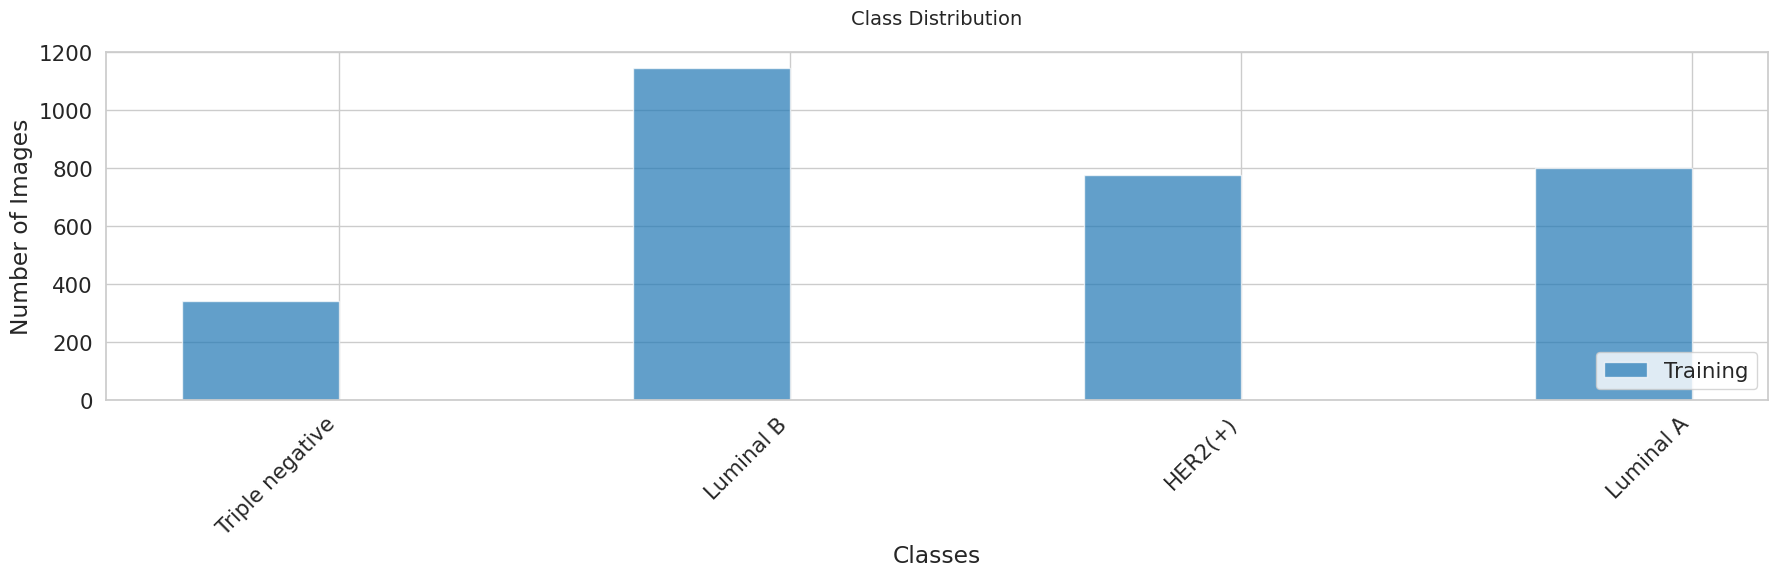


Class Distribution for Validation Set:


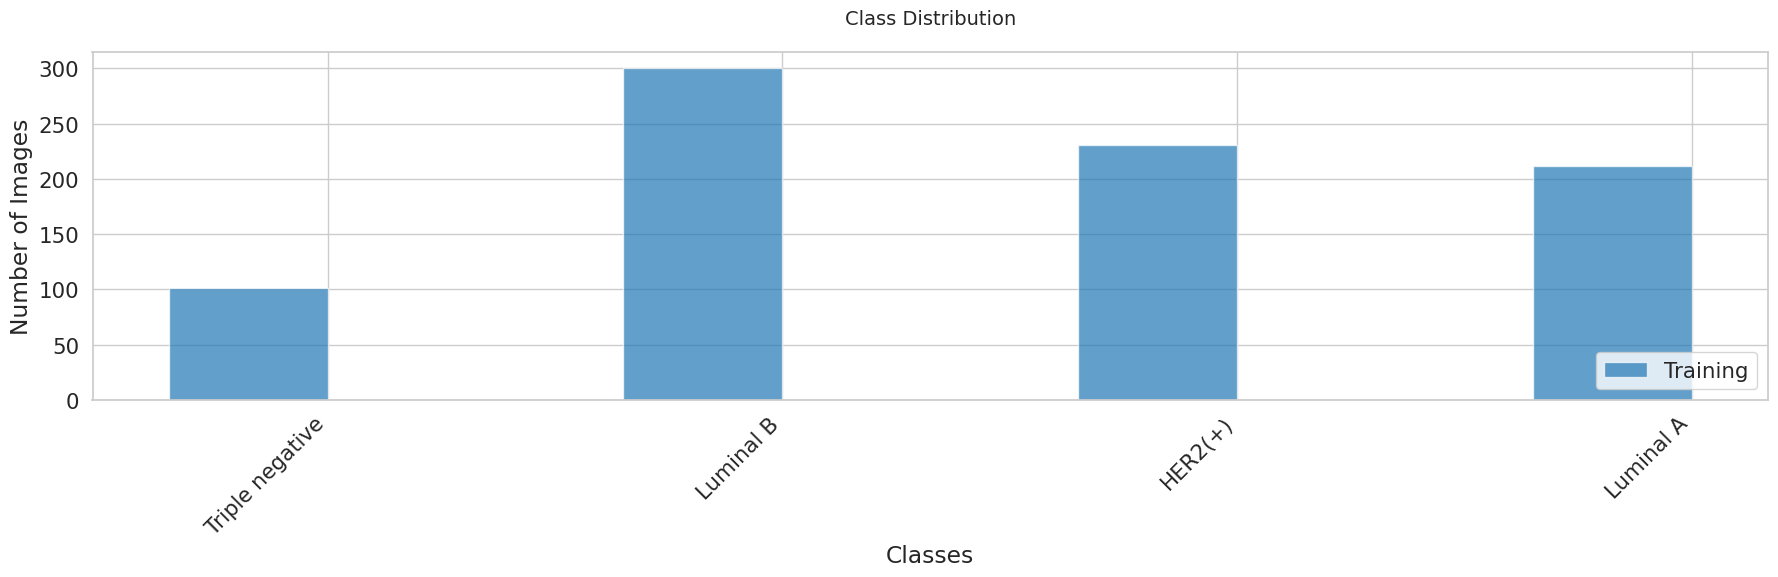

In [ ]:
# Plot class distribution for the training set
print("Class Distribution for Training Set:")
plot_class_distribution(y_train_new, class_to_id.keys())


# Plot class distribution for the validation set
print("\nClass Distribution for Validation Set:")
plot_class_distribution(y_val_new, class_to_id.keys())

In [ ]:
# Define the batch size, which is the number of samples in each batch
BATCH_SIZE = 128

In [ ]:
def make_loader(ds, batch_size, shuffle, drop_last):
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

In [ ]:
# Create data loaders with different settings for each phase
train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [ ]:
# Get one batch from the training data loader
for xb, yb in train_loader:
    print("Features batch shape:", xb.shape)
    print("Labels batch shape:", yb.shape)
    break # Stop after getting one batch

Features batch shape: torch.Size([128, 3, 224, 224])
Labels batch shape: torch.Size([128])


## 🧮 **Network Parameters**

In [ ]:
# Number of training epochs
LEARNING_RATE = 1e-3
EPOCHS = 1000
PATIENCE = 50

# Regularisation
DROPOUT_RATE = 0         # Dropout probability
L1_LAMBDA = 0            # L1 penalty
L2_LAMBDA = 0            # L2 penalty

# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Print the defined parameters
print("Epochs:", EPOCHS)
print("Batch Size:", BATCH_SIZE)
print("Learning Rare:", LEARNING_RATE)
print("Dropout Rate:", DROPOUT_RATE)
print("L1 Penalty:", L1_LAMBDA)
print("L2 Penalty:", L2_LAMBDA)

Epochs: 1000
Batch Size: 128
Learning Rare: 0.001
Dropout Rate: 0
L1 Penalty: 0
L2 Penalty: 0


## 👁️ **Simple CNN**

In [ ]:
# CNN Architecture parameters
# Number of convolutional blocks
NUM_BLOCKS = 2

# Number of conv layers per block
CONVS_PER_BLOCK = 1

# Use strided convolutions instead of pooling
USE_STRIDE = False

# Stride value when USE_STRIDE is True
STRIDE_VALUE = 2

# Padding size
PADDING_SIZE = 1

# Pooling size when USE_STRIDE is False
POOL_SIZE = 2

# Number of channels in first block (we start from 3 (RGB) -> 32 :number of feature maps)
INITIAL_CHANNELS = 32

# Channel multiplication factor between blocks
CHANNEL_MULTIPLIER = 2

print("Num Blocks:", NUM_BLOCKS)
print("Convs per Block:", CONVS_PER_BLOCK)
print("Use Stride:", USE_STRIDE)
print("Stride Value:", STRIDE_VALUE)
print("Padding Size:", PADDING_SIZE)
print("Pool Size:", POOL_SIZE)
print("Initial Channels:", INITIAL_CHANNELS)
print("Channel Multiplier:", CHANNEL_MULTIPLIER)

Num Blocks: 2
Convs per Block: 1
Use Stride: False
Stride Value: 2
Padding Size: 1
Pool Size: 2
Initial Channels: 32
Channel Multiplier: 2


In [ ]:
# Single convolutional block with multiple conv layers, ReLU and pooling/stride
class VanillaCNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_convs=1, use_stride=False, stride_value=2, padding_size=1, pool_size=2):
        super().__init__()

        layers = []

        # First convolution: in_channels -> out_channels
        if num_convs == 1:
            # Single conv: apply stride here if use_stride is True
            stride = stride_value if use_stride else 1
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=padding_size, stride=stride))
        else:
            # Multiple convs: first one always has stride=1
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1))

            # Intermediate convolutions (all with stride=1)
            for i in range(1, num_convs - 1):
                layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1))

            # Last convolution: apply stride here if use_stride is True
            stride = stride_value if use_stride else 1
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=padding_size, stride=stride))

        # ReLU activation
        layers.append(nn.ReLU())

        # Pooling only if not using stride for spatial reduction
        if not use_stride:
            layers.append(nn.MaxPool2d(kernel_size=pool_size, stride=pool_size))

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


# Convolutional Neural Network architecture for CIFAR10 classification
class CNN(nn.Module):
    def __init__(self, input_shape=(3,32,32), num_classes=10, dropout_rate=DROPOUT_RATE,
                 num_blocks=NUM_BLOCKS, convs_per_block=CONVS_PER_BLOCK,
                 use_stride=USE_STRIDE, stride_value=STRIDE_VALUE, padding_size=PADDING_SIZE, pool_size=POOL_SIZE,
                 initial_channels=INITIAL_CHANNELS, channel_multiplier=CHANNEL_MULTIPLIER):
        super().__init__()

        # Build convolutional blocks
        blocks = []
        in_channels = input_shape[0]
        out_channels = initial_channels

        for i in range(num_blocks):
            blocks.append(VanillaCNNBlock(
                in_channels=in_channels,
                out_channels=out_channels,
                num_convs=convs_per_block,
                use_stride=use_stride,
                stride_value=stride_value,
                padding_size=padding_size,
                pool_size=pool_size
            ))

            # Prepare for next block: increase channels
            in_channels = out_channels
            out_channels = out_channels * channel_multiplier

        self.features = nn.Sequential(*blocks)

        # Calculate flattened size after all blocks using a dummy forward pass
        # This approach is robust and works with any configuration of padding, stride, and pooling
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            dummy_output = self.features(dummy_input)
            flattened_size = dummy_output.view(1, -1).shape[1]

        # Classification head: flatten features and apply dropout before final layer
        self.classifier_head = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout_rate),
            nn.Linear(flattened_size, num_classes)
        )

    # Forward pass through the network
    def forward(self, x):
        x = self.features(x)
        x = self.classifier_head(x)
        return x

In [ ]:
# Instantiate CNN model and move to computing device (CPU/GPU)
cnn_model = CNN(
    input_shape,
    num_classes,
    num_blocks=NUM_BLOCKS,
    convs_per_block=CONVS_PER_BLOCK,
    use_stride=USE_STRIDE,
    stride_value=STRIDE_VALUE,
    padding_size=PADDING_SIZE,
    pool_size=POOL_SIZE,
    initial_channels=INITIAL_CHANNELS,
    channel_multiplier=CHANNEL_MULTIPLIER
    ).to(device)

# Display model architecture summary
summary(cnn_model, input_size=input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
         MaxPool2d-3         [-1, 32, 112, 112]               0
   VanillaCNNBlock-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]          18,496
              ReLU-6         [-1, 64, 112, 112]               0
         MaxPool2d-7           [-1, 64, 56, 56]               0
   VanillaCNNBlock-8           [-1, 64, 56, 56]               0
           Flatten-9               [-1, 200704]               0
          Dropout-10               [-1, 200704]               0
           Linear-11                    [-1, 4]         802,820
Total params: 822,212
Trainable params: 822,212
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/

In [ ]:
# Set up TensorBoard logging and save model architecture
experiment_name = "cnn_baseline_patches"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)
x = torch.randn(1, input_shape[0], input_shape[1], input_shape[2]).to(device)
writer.add_graph(cnn_model, x)

# Define optimizer with L2 regularization
optimizer = torch.optim.AdamW(cnn_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

## 🧠 **Model Training**

In [ ]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

In [ ]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm


        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

In [ ]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_accuracy

In [ ]:
def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):
    """
    Log training metrics and model parameters to TensorBoard for visualization.

    Args:
        writer (SummaryWriter): TensorBoard SummaryWriter object for logging
        epoch (int): Current epoch number (used as x-axis in TensorBoard plots)
        train_loss (float): Training loss for this epoch
        train_f1 (float): Training f1 score for this epoch
        val_loss (float): Validation loss for this epoch
        val_f1 (float): Validation f1 score for this epoch
        model (nn.Module): The neural network model (for logging weights/gradients)

    Note:
        This function logs scalar metrics (loss/f1 score) and histograms of model
        parameters and gradients, which helps monitor training progress and detect
        issues like vanishing/exploding gradients.
    """
    # Log scalar metrics
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty before adding a histogram
            if param.numel() > 0:
                writer.add_histogram(f'{name}/weights', param.data, epoch)
            if param.grad is not None:
                # Check if the gradient tensor is not empty before adding a histogram
                if param.grad.numel() > 0:
                    if param.grad is not None and torch.isfinite(param.grad).all():
                        writer.add_histogram(f'{name}/gradients', param.grad.data, epoch)

In [ ]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)
            wip_folder = "models"

            # Create the folder if it doesn't exist
            os.makedirs(wip_folder, exist_ok=True)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

In [ ]:
%%time
# Train model and track training history
cnn_model, training_history = fit(
    model=cnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=1,
    experiment_name="cnn_baseline_senza_shrek_e_slime",
    patience=PATIENCE
    )

# Update best model if current performance is superior
if training_history['val_f1'][-1] > best_performance:
    best_model = cnn_model
    best_performance = training_history['val_f1'][-1]

Training 1000 epochs...
Epoch   1/1000 | Train: Loss=3.8256, F1 Score=0.2771 | Val: Loss=1.3847, F1 Score=0.1850
Epoch   2/1000 | Train: Loss=1.3444, F1 Score=0.2051 | Val: Loss=1.3588, F1 Score=0.1864
Epoch   3/1000 | Train: Loss=1.3207, F1 Score=0.2259 | Val: Loss=1.3626, F1 Score=0.1864
Epoch   4/1000 | Train: Loss=1.3284, F1 Score=0.2116 | Val: Loss=1.3484, F1 Score=0.1846
Epoch   5/1000 | Train: Loss=1.3105, F1 Score=0.2321 | Val: Loss=1.3435, F1 Score=0.1765
Epoch   6/1000 | Train: Loss=1.2915, F1 Score=0.2471 | Val: Loss=1.3981, F1 Score=0.1813
Epoch   7/1000 | Train: Loss=1.2940, F1 Score=0.2515 | Val: Loss=1.3483, F1 Score=0.1837
Epoch   8/1000 | Train: Loss=1.2733, F1 Score=0.2862 | Val: Loss=1.3550, F1 Score=0.2230
Epoch   9/1000 | Train: Loss=1.2408, F1 Score=0.3241 | Val: Loss=1.3720, F1 Score=0.1806
Epoch  10/1000 | Train: Loss=1.2021, F1 Score=0.3579 | Val: Loss=1.3801, F1 Score=0.2352
Epoch  11/1000 | Train: Loss=1.1567, F1 Score=0.4088 | Val: Loss=1.3787, F1 Score=0.24

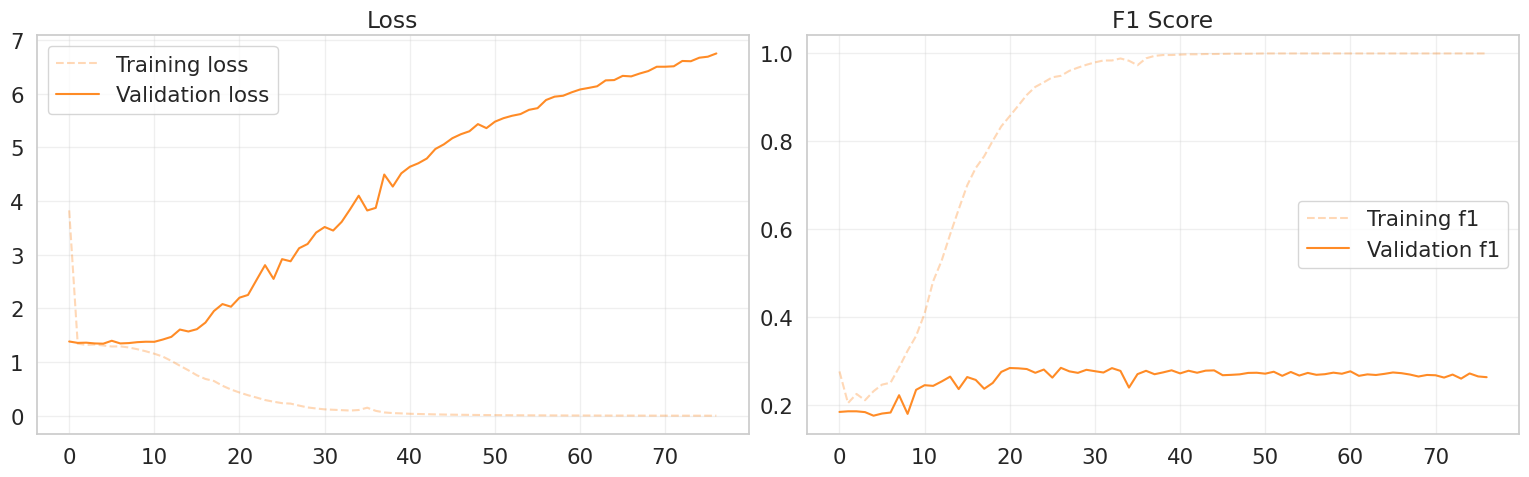

In [ ]:
# @title Plot Hitory
# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(training_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(training_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(training_history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(training_history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

Accuracy over the validation set: 0.2867
Precision over the validation set: 0.2881
Recall over the validation set: 0.2867
F1 score over the validation set: 0.2853


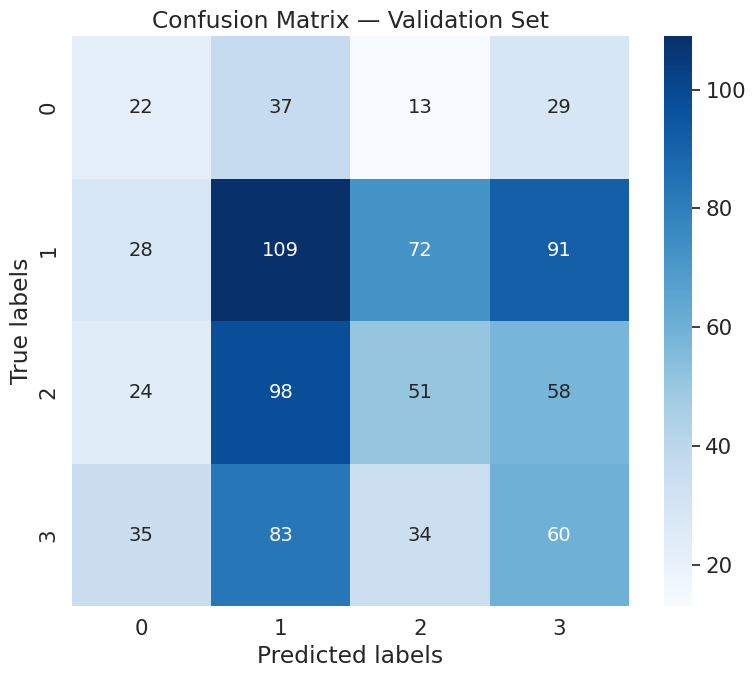

In [ ]:
# @title Plot Confusion Matrix
# Collect predictions and ground truth labels
val_preds, val_targets = [], []
with torch.no_grad():  # Disable gradient computation for inference
    for xb, yb in val_loader:
        xb = xb.to(device)

        # Forward pass: get model predictions
        logits = cnn_model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()

        # Store batch results
        val_preds.append(preds)
        val_targets.append(yb.numpy())

# Combine all batches into single arrays
val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# Calculate overall validation metrics
val_acc = accuracy_score(val_targets, val_preds)
val_prec = precision_score(val_targets, val_preds, average='weighted')
val_rec = recall_score(val_targets, val_preds, average='weighted')
val_f1 = f1_score(val_targets, val_preds, average='weighted')
print(f"Accuracy over the validation set: {val_acc:.4f}")
print(f"Precision over the validation set: {val_prec:.4f}")
print(f"Recall over the validation set: {val_rec:.4f}")
print(f"F1 score over the validation set: {val_f1:.4f}")

# Generate confusion matrix for detailed error analysis
cm = confusion_matrix(val_targets, val_preds)

# Create numeric labels for heatmap annotation
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='',
            cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set')
plt.tight_layout()
plt.show()

In [ ]:
# @title Activation visualisation
def get_activation(name):
    """Creates a hook function to capture and store layer outputs."""
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook


def find_last_conv_layer(model):
    """
    Identifies the final Conv2D layer in the model architecture.
    """
    last_conv_name = None
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            last_conv_name = name

    if last_conv_name is None:
        raise ValueError("No Conv2D layer found in the model.")
    return last_conv_name


def visualize(model, X, y, unique_labels, num_images=50, display_activations=True, display_all_conv_layers=False):
    """
    Visualises model predictions and internal activations for a random test image.
    Uses PyTorch hooks to extract intermediate layer outputs.

    Args:
        display_all_conv_layers: If True, shows all conv layers. If False, shows only last conv of each block.
    """

    # --- 1. Select Image and Prepare Tensor ---

    # Randomly select an image from the dataset
    image_idx = np.random.randint(0, num_images)
    img_np = X[image_idx]
    label_np = y[image_idx]

    # Convert NumPy array to PyTorch tensor with correct dimensions
    # Transform from (H, W, C) to (N, C, H, W) format
    img_tensor = torch.from_numpy(img_np)
    img_tensor = img_tensor.permute(2, 0, 1)
    img_tensor = img_tensor.unsqueeze(0).to(device)

    # --- 2. Register Hooks and Make Prediction ---

    # Clear previous activations
    activations.clear()

    # Attach forward hooks to convolutional layers
    hooks = []
    conv_names = []

    # Iterate through all blocks in the features Sequential
    for block_idx, block in enumerate(model.features):
        # Find all Conv2d layers in this block
        conv_layers_in_block = []
        for layer_idx, layer in enumerate(block.block):
            if isinstance(layer, nn.Conv2d):
                conv_layers_in_block.append((layer_idx, layer))

        # Register hooks based on display_all_conv_layers flag
        if display_all_conv_layers:
            # Register hook for every Conv2d layer
            for layer_idx, conv_layer in conv_layers_in_block:
                hook_name = f'block{block_idx}_conv{layer_idx}'
                conv_names.append(hook_name)
                hooks.append(conv_layer.register_forward_hook(get_activation(hook_name)))
        else:
            # Register hook only for the last Conv2d layer in this block
            if conv_layers_in_block:
                layer_idx, conv_layer = conv_layers_in_block[-1]
                hook_name = f'block{block_idx}_conv{layer_idx}'
                conv_names.append(hook_name)
                hooks.append(conv_layer.register_forward_hook(get_activation(hook_name)))

    # Generate prediction with gradient tracking disabled
    model.eval()
    with torch.no_grad():
        logits = model(img_tensor)
        probabilities = torch.softmax(logits, dim=1)

    # Remove hooks after forward pass
    for hook in hooks:
        hook.remove()

    # Extract predicted class and confidence
    predictions = probabilities.cpu().numpy()
    class_int = np.argmax(predictions[0])
    class_str = unique_labels[class_int]

    # Extract true class (handle both one-hot encoded and integer labels)
    if label_np.ndim > 0 and len(label_np) > 1:
        # One-hot encoded
        true_class_int = np.argmax(label_np)
    else:
        # Already an integer index
        true_class_int = int(label_np)
    true_class_str = unique_labels[true_class_int]

    # --- 3. Plot Image and Prediction Bar ---

    # Create figure with custom layout
    fig = plt.figure(constrained_layout=True, figsize=(16, 4))
    gs = gridspec.GridSpec(1, 2, figure=fig, width_ratios=[1.5, 1.5], wspace=0)

    # Display original image with true label
    ax1 = fig.add_subplot(gs[0])
    ax1.set_title(f"True class: {true_class_str}", loc='left')
    if img_np.shape[-1] == 1:
        ax1.imshow(np.squeeze(img_np), cmap='bone', vmin=0., vmax=1.)
    else:
        ax1.imshow(np.squeeze(img_np), vmin=0., vmax=1.)
    ax1.axis('off')

    # Display class probability distribution
    ax2 = fig.add_subplot(gs[1])
    ax2.barh(unique_labels, np.squeeze(predictions, axis=0), color=plt.get_cmap('tab10').colors)
    ax2.set_title(f"Predicted class: {class_str} (Confidence: {max(np.squeeze(predictions[0])):.2f})", loc='left')
    ax2.grid(alpha=0.3)
    ax2.set_xlim(0.0, 1.0)
    plt.show()

    # --- 4. Plot Activations ---

    if display_activations:
        # Visualise activations for each registered layer
        for conv_name in conv_names:
            # Retrieve stored activations from hooks
            layer_activations = activations[conv_name]

            # Get number of channels
            num_channels = layer_activations.shape[1]

            # Display up to 16 feature maps per layer
            num_display = min(16, num_channels)

            # Calculate grid layout
            if num_display <= 8:
                rows, cols = 1, num_display
                figsize = (18, 3)
            else:
                rows, cols = 2, 8
                figsize = (18, 5)

            # Create subplot grid
            fig, axes = plt.subplots(rows, cols, figsize=figsize)

            # Flatten axes array for easier indexing
            if num_display > 1:
                axes = axes.flatten() if rows > 1 or cols > 1 else [axes]
            else:
                axes = [axes]

            # Plot each activation map
            for i in range(num_display):
                ax = axes[i]
                activation_map = layer_activations[0, i].cpu().numpy()
                ax.imshow(activation_map, cmap='bone', vmin=np.min(activation_map), vmax=np.max(activation_map))
                ax.axis('off')
                if i == 0:
                    ax.set_title(f'{conv_name} activations', loc='left')

            # Hide unused subplots
            for i in range(num_display, len(axes)):
                axes[i].axis('off')

            plt.tight_layout()
            plt.show()

## SAVE MODEL

In [ ]:
from datetime import datetime
model=cnn_model
# Directory dove salvare
save_dir = 'saved_models/'
os.makedirs(save_dir, exist_ok=True)

# Esempio dati
model_id = experiment_name #RIEMPIRE QUI CON TIPO DI MODELLO

# Salva il modello
model_path = os.path.join(save_dir, f'model_{model_id}_f1_{val_f1:.2f}.pth')
torch.save(model.state_dict(), model_path)

# Aggiorna CSV delle metriche
metrics_file = os.path.join(save_dir, 'metrics.csv')
if os.path.exists(metrics_file):
    df_metrics = pd.read_csv(metrics_file)
else:
    df_metrics = pd.DataFrame(columns=['model_id','val_acc','val_prec','val_rec','val_f1', 'timestamp', 'path'])

df_metrics = pd.concat([df_metrics, pd.DataFrame([{
    'model_id': model_id,
    'val_acc' : val_acc,
    'val_prec' : val_prec,
    'val_rec' : val_rec,
    'val_f1' : val_f1,
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'path': model_path
}])], ignore_index=True)

df_metrics.to_csv(metrics_file, index=False)

if os.path.exists(model_path):
    print(f"✅ Modello salvato correttamente in: {model_path}")
else:
    print("❌ Errore: il modello non è stato salvato")


✅ Modello salvato correttamente in: saved_models/model_cnn_baseline_patches_f1_0.29.pth
